In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/nihargajre/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/nihargajre/.fastai/data/camvid/images'),
 PosixPath('/home/nihargajre/.fastai/data/camvid/labels'),
 PosixPath('/home/nihargajre/.fastai/data/camvid/valid.txt')]

In [6]:
path_label = path / 'labels'
path_imgs = path / 'images'

## Data

In [7]:
fnames = get_image_files(path_imgs)

In [8]:
fnames[:3]

[PosixPath('/home/nihargajre/.fastai/data/camvid/images/0001TP_010320.png'),
 PosixPath('/home/nihargajre/.fastai/data/camvid/images/0006R0_f02700.png'),
 PosixPath('/home/nihargajre/.fastai/data/camvid/images/Seq05VD_f03330.png')]

In [9]:
label_names = get_image_files(path_label)
label_names[:3]

[PosixPath('/home/nihargajre/.fastai/data/camvid/labels/0016E5_05280_P.png'),
 PosixPath('/home/nihargajre/.fastai/data/camvid/labels/Seq05VD_f03360_P.png'),
 PosixPath('/home/nihargajre/.fastai/data/camvid/labels/0016E5_07170_P.png')]

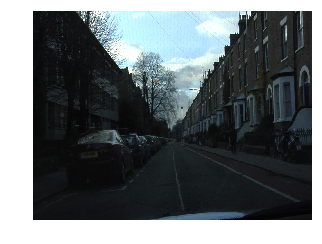

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [11]:
get_y_fn = lambda x: path_label / f'{x.stem}_P{x.suffix}'

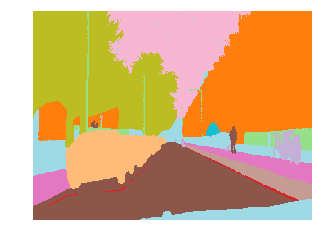

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size

array([720, 960])

In [14]:
mask.data

tensor([[[26, 26, 26,  ...,  4,  4,  4],
         [26, 26, 26,  ...,  4,  4,  4],
         [26, 26, 26,  ...,  4,  4,  4],
         ...,
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30]]])

In [15]:
codes = np.loadtxt(path / 'codes.txt', dtype=str)
codes 

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [16]:
size = src_size // 2
bs = 8

In [17]:
src = (ImageFileList.from_folder(path_imgs)
                    .label_from_func(get_y_fn)
                    .split_by_fname_file('../valid.txt'))

In [18]:
data = src.datasets(SegmentationDataset, classes=codes)\
          .transform(get_transforms(), size=size, tfm_y=True)\
          .databunch(bs=bs)\
          .normalize(imagenet_stats)

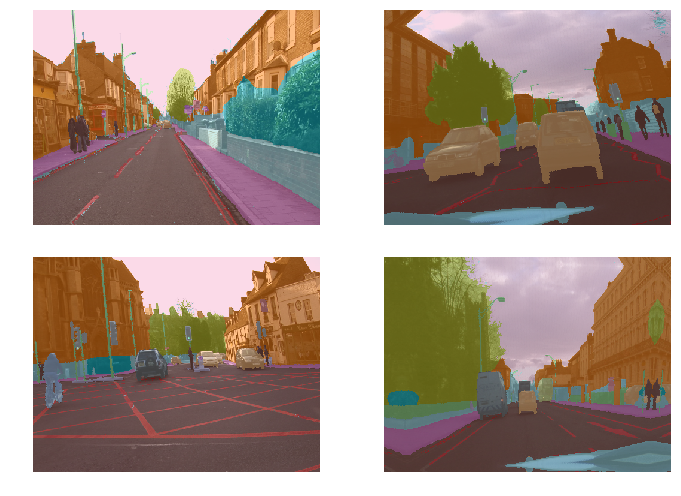

In [19]:
data.show_batch(2, figsize=(10, 7))

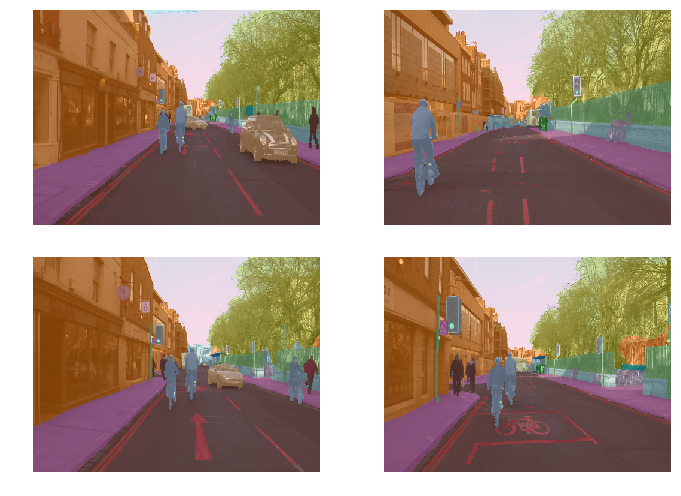

In [20]:
data.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid)

## Models

In [28]:
name2vid = {v:k for k, v in enumerate(codes)}
void_code = name2vid['Void']

In [35]:
def acc_camvid(input, target):
    """
    Custom accuracy function to account for void annotations
    """
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [36]:
metrics=acc_camvid

In [37]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


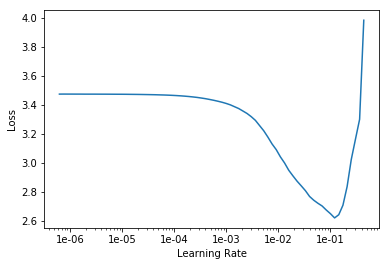

In [38]:
lr_find(learn)
learn.recorder.plot()

In [39]:
lr = 1e-2

In [40]:
learn.fit_one_cycle(10, slice(lr))

Total time: 02:56
epoch  train_loss  valid_loss  acc_camvid
1      1.530541    1.060102    0.814409    (00:18)
2      0.898210    0.712310    0.830262    (00:17)
3      0.707350    0.550253    0.855426    (00:17)
4      0.663340    0.509297    0.867083    (00:17)
5      0.596120    0.486186    0.868227    (00:17)
6      0.542702    0.468406    0.871275    (00:17)
7      0.505860    0.404233    0.888343    (00:17)
8      0.461147    0.387473    0.884747    (00:17)
9      0.428876    0.362562    0.895547    (00:17)
10     0.412706    0.355058    0.894914    (00:17)



In [41]:
learn.save('stage-1')

In [42]:
learn.load('stage-1')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7fdb69f7f400>, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn

In [43]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


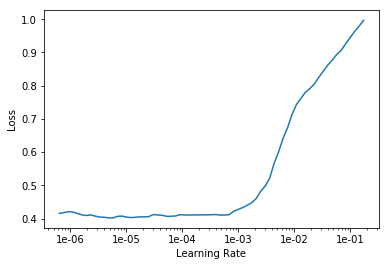

In [44]:
lr_find(learn)
learn.recorder.plot()

In [45]:
lrs = slice(1e-5, lr / 5)

In [46]:
learn.fit_one_cycle(12, lrs)

Total time: 03:46
epoch  train_loss  valid_loss  acc_camvid
1      0.413624    0.352697    0.897306    (00:18)
2      0.409423    0.354570    0.896680    (00:18)
3      0.416816    0.354862    0.896080    (00:18)
4      0.404906    0.349655    0.896686    (00:18)
5      0.403582    0.372752    0.888328    (00:18)
6      0.386152    0.344373    0.897937    (00:18)
7      0.374797    0.321160    0.908061    (00:18)
8      0.363453    0.307378    0.912586    (00:18)
9      0.344733    0.308014    0.911563    (00:18)
10     0.330773    0.304570    0.912996    (00:18)
11     0.324213    0.303884    0.912844    (00:19)
12     0.322284    0.300884    0.913762    (00:18)



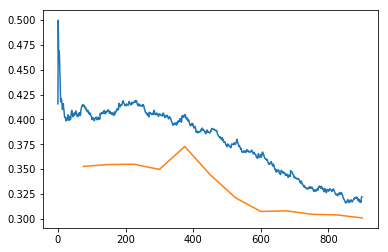

In [47]:
learn.recorder.plot_losses()

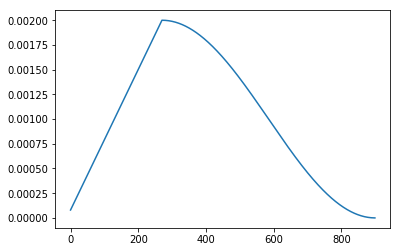

In [48]:
learn.recorder.plot_lr()

In [49]:
learn.save('stage-2')

## Go Big

In [50]:
size = src_size
bs = 4

In [51]:
data = (src.datasets(SegmentationDataset, classes=codes)
           .transform(get_transforms(), size=size, tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats))

In [53]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [54]:
learn.load('stage-2')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7fdb6828b0f0>, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


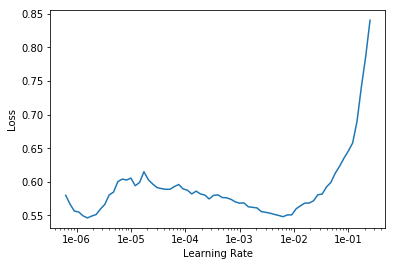

In [55]:
lr_find(learn)
learn.recorder.plot()

In [56]:
lr = 1e-3

In [57]:
learn.fit_one_cycle(10, slice(lr))

Total time: 08:32
epoch  train_loss  valid_loss  acc_camvid
1      0.469090    0.370888    0.895845    (00:55)
2      0.431025    0.366685    0.896583    (00:50)
3      0.409149    0.354775    0.898362    (00:50)
4      0.387167    0.321822    0.906109    (00:50)
5      0.369854    0.322719    0.905218    (00:50)
6      0.355720    0.315829    0.909041    (00:50)
7      0.338964    0.314464    0.909714    (00:50)
8      0.323381    0.308199    0.912742    (00:50)
9      0.317738    0.304771    0.913290    (00:50)
10     0.305664    0.300566    0.914108    (00:50)



In [58]:
learn.save('stage-1-big')

In [59]:
learn.load('stage-1-big');

In [60]:
learn.unfreeze()

In [61]:
lrs = slice(1e-6, lr)

In [62]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 09:25
epoch  train_loss  valid_loss  acc_camvid
1      0.313413    0.306393    0.912087    (00:56)
2      0.319998    0.292814    0.919921    (00:56)
3      0.320376    0.290852    0.913230    (00:56)
4      0.311867    0.292313    0.920739    (00:56)
5      0.304402    0.303622    0.916792    (00:56)
6      0.298094    0.297169    0.918390    (00:56)
7      0.281177    0.292924    0.919512    (00:56)
8      0.268546    0.280087    0.923207    (00:56)
9      0.256941    0.280092    0.923857    (00:56)
10     0.253528    0.278529    0.923930    (00:56)



In [63]:
learn.save('stage-2-big')

In [64]:
learn.load('stage-2-big');

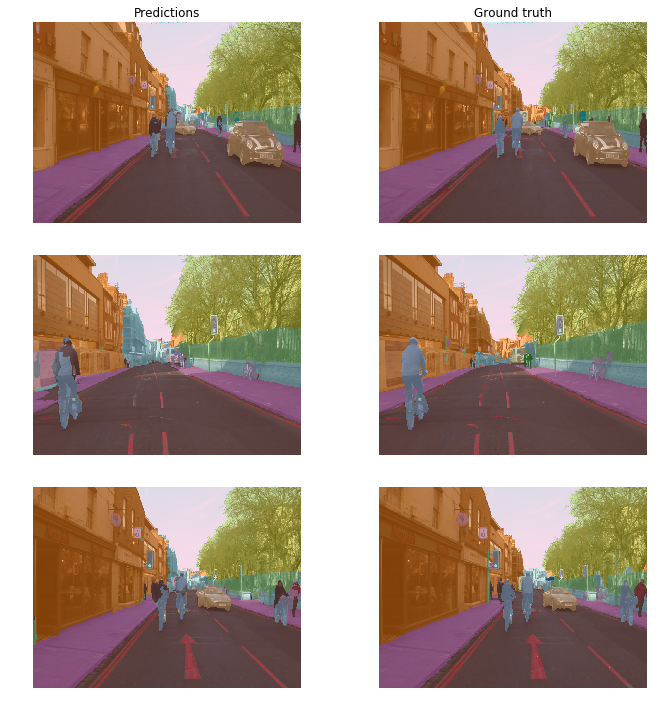

In [67]:
learn.show_results(figsize=(10, 10))